# Мастерская Лента

## Описание задачи

Построить модель прогноза спроса на 14 дней для товаров собственного производства на основе мастер данных и данных продаж с учетом разных признаков. Гранулярность ТК-SKU-День.

Прогноз позволит повысить доступность и продажи в ТК, без повышения списаний и повышение маржинальности. При изготовлении товаров СП сотрудники будут ориентироваться не на экспертный подход, а на ML прогноз спроса, в соответствии с которым будут изготавливать продукцию и планировать заказы сырья.

## Знакомство с данными

Бизнес-заказчиком передано 3 датасета: `pr_df.csv`, `sales_df_train.csv`, `sf_df.csv`:

1. Датасет `sales_df_train.csv` содержит данные по продажам за скользящий год для обучения.

    Столбцы:

    `st_id` – захэшированное id магазина;

    `pr_sku_id` – захэшированное id товара;

    `date` – дата;

    `pr_sales_type_id` – флаг наличия промо;

    `pr_sales_in_units` – число проданных товаров всего (промо и без промо);

    `pr_promo_sales_in_units` – число проданных товаров с признаком промо;

    `pr_sales_in_rub` – продажи всего (промо и без промо) в РУБ;

    `pr_promo_sales_in_rub` – продажи с признаком промо в РУБ;

2. Датасет `pr_df.csv` содержит данные по товарной иерархии. Иерархия представлена последовательностью от большего к меньшему `pr_group_id` - `pr_cat_id` - `pr_subcat_id` - `pr_sku_id`.

    Столбцы:

    `pr_group_id` – захэшированная группа товара;

    `pr_cat_id` – захэшированная категория товара;

    `pr_subcat_id` – захэшированная подкатегория товара;

    `pr_sku_id` – захэшированное id товара;

    `pr_uom_id` (маркер, обозначающий продаётся товар на вес или в ШТ).

3. Датасет `sf_df.csv` содержит данные по магазинам.

    Столбцы:

    `st_id` – захэшированное id магазина;

    `st_city_id` – захэшированное id города;

    `st_division_code id` – захэшированное id дивизиона;
    
    `st_type_format_id` – id формата магазина;

    `st_type_loc_id` – id тип локации/окружения магазина;
    
    `st_type_size_id` – id типа размера магазина;

    `st_is_active` – флаг активного магазина на данный момент.

Импортируем необходимые библиотеки:

In [ ]:
pip install tsfresh

In [ ]:
pip install phik

In [ ]:
import datetime as DT

import phik

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from scipy.stats import norm

from scipy import stats

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.tsa.seasonal import seasonal_decompose

from tsfresh import select_features, extract_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction.settings import from_columns
from tsfresh.feature_extraction import settings

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


Прочитаем представленные данные и посмотрим общую информацию о них:

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pr_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lenta/pr_df.csv')

In [ ]:
sales_df_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lenta/sales_df_train.csv')

In [ ]:
sf_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lenta/st_df.csv')

In [ ]:
def read_data(data):
    print(data.info())
    print(data.head())
    print(data.describe())

#### Анализ товарной иерархии

In [ ]:
read_data(pr_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB
None
                          pr_sku_id                       pr_group_id  \
0  fd064933250b0bfe4f926b867b0a5ec8  c74d97b01eae257e44aa9d5bade97baf   
1  71c9661741caf40a92a32d1cc8206c04  c74d97b01eae257e44aa9d5bade97baf   
2  00b72c2f01a1512cbb1d3f33319bac93  c74d97b01eae257e44aa9d5bade97baf   
3  9bc40cd2fe4f188f402bb41548c5e15c  c74d97b01eae257e44aa9d5bade97baf   
4  3a74a370c8eb032acb11ad9119242b8f  c74d97b01eae257e44aa9d5bade97baf   

                          pr_cat_id                      pr_subcat_id  \
0  1bc0249a6412ef49b07fe6f62e6dc

In [ ]:
pr_df['pr_uom_id'].value_counts().to_frame()

,pr_uom_id
1,1279
17,771


In [ ]:
pr_df['pr_group_id'].nunique()

9

<Axes: >

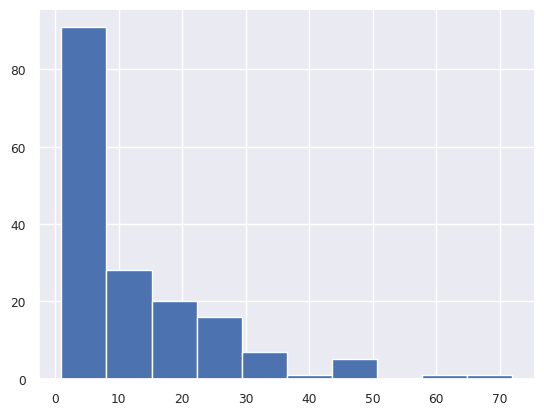

In [ ]:
pr_df.groupby(['pr_group_id', 'pr_cat_id', 'pr_subcat_id'])['pr_sku_id'].count().hist()

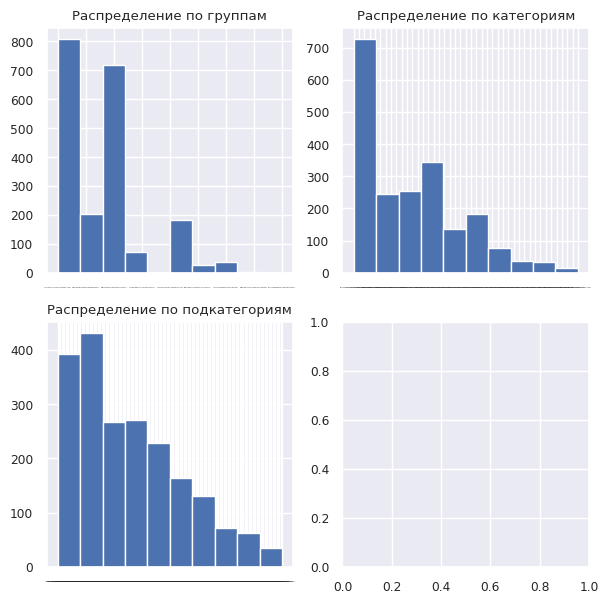

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
pr_df.pr_group_id.hist(xlabelsize=0, ax=axs[0,0]).set_title('Распределение по группам')
pr_df.pr_cat_id.hist(xlabelsize=0, ax=axs[0,1]).set_title('Распределение по категориям')
pr_df.pr_subcat_id.hist(xlabelsize=0, ax=axs[1,0]).set_title('Распределение по подкатегориям');

Количество групп товаров: 9

Количество категорий товаров: 43

Количество подкатегорий товаров: 170

Количество товаров: 2050

#### Анализ продаж

In [ ]:
read_data(sales_df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB
None
                              st_id                         pr_sku_id  \
0  c81e728d9d4c2f636f067f89cc14862c  c7b711619071c92bef604c7ad68380dd   
1  42a0e188f5033bc65bf8d78622277c4e  68f441429e73dbd33b81f95da31576e9   
2  1ecfb463472ec9115b10c292ef8bc986  22988026fe85fde6

In [ ]:
sales_df_train['date'] = pd.to_datetime(sales_df_train['date'])

In [ ]:
sns.set_palette("Set2")

Распределения категориальных признаков


[]

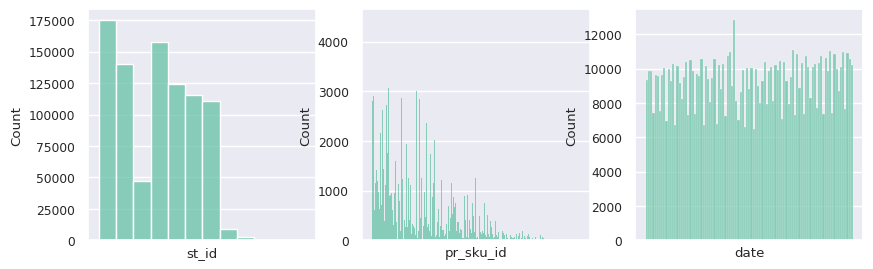

In [ ]:
print('Распределения категориальных признаков')
fig, axs = plt.subplots(ncols=3, figsize=(10, 3))
sns.histplot(data=sales_df_train['st_id'], ax=axs[0]).set_xticks([])
sns.histplot(data=sales_df_train['pr_sku_id'], ax=axs[1]).set_xticks([])
sns.histplot(data=sales_df_train['date'], ax=axs[2]).set_xticks([])

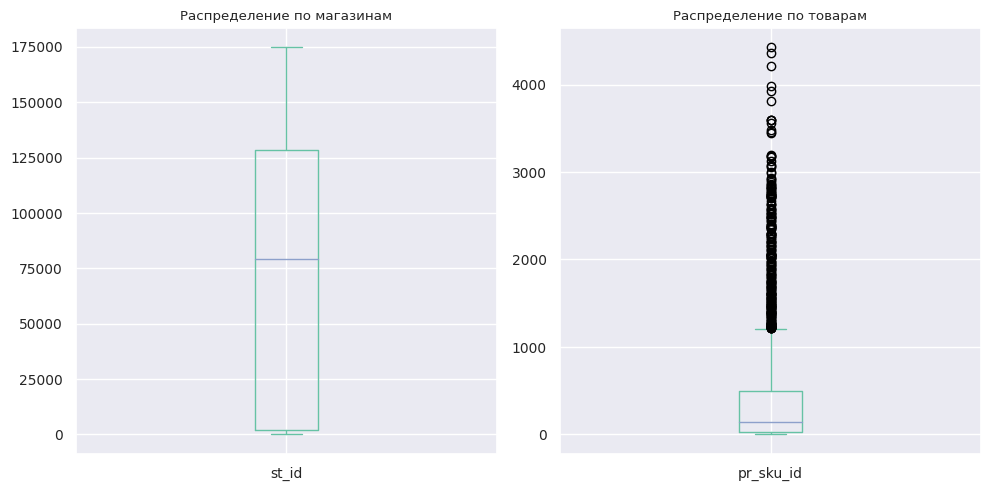

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
font_size=10
sales_df_train['st_id'].value_counts().plot.box(fontsize=font_size, ax=axs[0]).set_title('Распределение по магазинам')
sales_df_train['pr_sku_id'].value_counts().plot.box(fontsize=font_size, ax=axs[1]).set_title('Распределение по товарам')
fig.tight_layout()

Видим, что распределение продаж в некоторых магазинах и некоторых товаров значительно отличаются, то же самое видно и во временных рядах. Посмотрим на цифры:

In [ ]:
sales_df_train['st_id'].value_counts().to_frame(name='Итого:')

,Итого:
c81e728d9d4c2f636f067f89cc14862c,174687
16a5cdae362b8d27a1d8f8c7b78b4330,157542
42a0e188f5033bc65bf8d78622277c4e,140286
f7e6c85504ce6e82442c770f7c8606f0,124145
6364d3f0f495b6ab9dcf8d3b5c6e0b01,115830
fa7cdfad1a5aaf8370ebeda47a1ff1c3,110537
1ecfb463472ec9115b10c292ef8bc986,47404
53e19f3dbb211f20b20b45668303c1b6,9231
bd470ca955d9497bbcb808e59952fffc,2586
1aa057313c28fa4a40c5bc084b11d276,719


In [ ]:
sales_df_train['pr_sku_id'].value_counts().to_frame(name='Итого:')

,Итого:
62d4af457ba2540ce0898a211c0cd17a,4424
ced0c1a84924c982a6403870c54b99ca,4362
cf91eca9321c9c272fb4e7cf4bcc6a43,4213
5b26f85ccb23039364226f66f0366c66,3982
6b1344097385a42484abd4746371e416,3929
...,...
8878e97692da06941dedcf44c1f50668,1
e18fadbb06e89f6f03545537c02b8bee,1
a4f2ee628051a3b73d6e1003ff6eaa5b,1
e65002dccbd12e07c33815a27e72a6cd,1


In [ ]:
sales_df_train['date'].value_counts().to_frame(name='Итого:')

,Итого:
2022-12-30,3396
2022-12-29,3322
2022-12-24,3233
2022-12-28,3126
2023-06-23,3033
...,...
2023-01-03,2083
2023-04-17,2070
2023-01-09,2041
2023-01-02,1950


Теперь посмотрим на распределение численных признаков тренировочного датасета:

In [ ]:
sales_df_train['pr_sales_type_id'].value_counts().to_frame(name='Итого:')

,Итого:
0,524082
1,358933


Распределения численных признаков


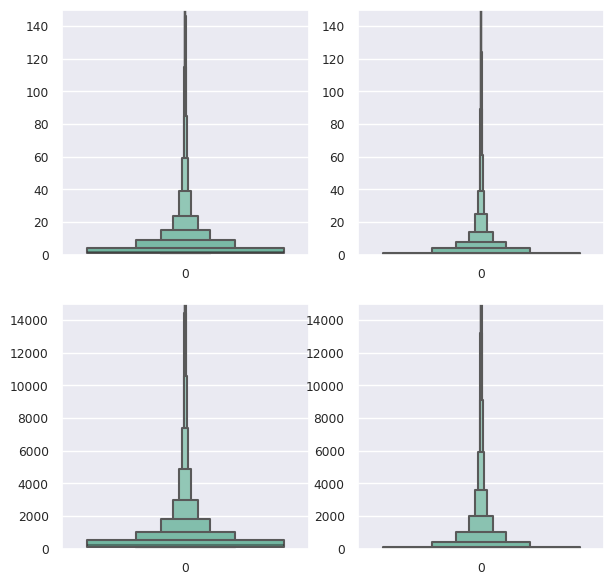

In [ ]:
print('Распределения численных признаков')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
sns.boxenplot(data=sales_df_train['pr_sales_in_units'], ax=axs[0,0]).set_ylim(0, 150)
sns.boxenplot(data=sales_df_train['pr_promo_sales_in_units'], ax=axs[0,1]).set_ylim(0, 150)
sns.boxenplot(data=sales_df_train['pr_sales_in_rub'], ax=axs[1,0]).set_ylim(0, 15000)
sns.boxenplot(data=sales_df_train['pr_promo_sales_in_rub'], ax=axs[1,1]).set_ylim(0, 15000);

Распределения численных признаков


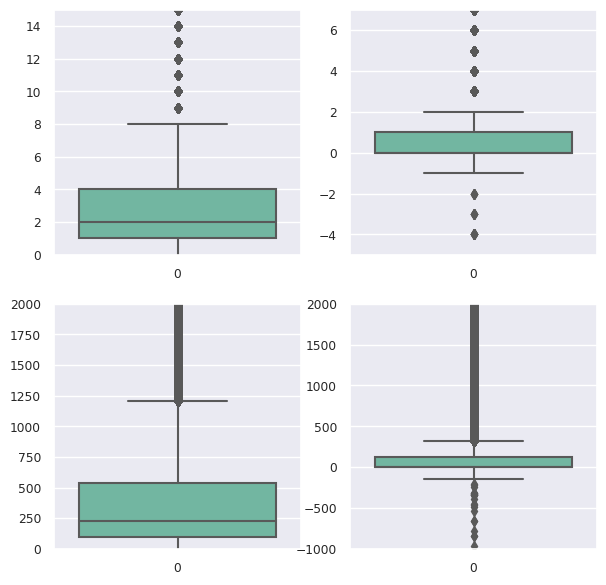

In [ ]:
print('Распределения численных признаков')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
sns.boxplot(data=sales_df_train['pr_sales_in_units'], ax=axs[0,0]).set_ylim(0, 15)
sns.boxplot(data=sales_df_train['pr_promo_sales_in_units'], ax=axs[0,1]).set_ylim(-5, 7)
sns.boxplot(data=sales_df_train['pr_sales_in_rub'], ax=axs[1,0]).set_ylim(0, 2000)
sns.boxplot(data=sales_df_train['pr_promo_sales_in_rub'], ax=axs[1,1]).set_ylim(-1000, 2000);

In [ ]:
sales_df_train[['pr_sales_in_units', 'pr_promo_sales_in_units',
                'pr_sales_in_rub', 'pr_promo_sales_in_rub']].describe()

,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
count,883015.000000,883015.000000,883015.000000,883015.000000
mean,5.037956,2.230010,596.705181,294.766561
std,13.402984,11.063288,1577.366179,1402.764168
min,-39.000000,-39.000000,-3373.000000,-3373.000000
25%,1.000000,0.000000,98.000000,0.000000
50%,2.000000,0.000000,224.000000,0.000000
75%,4.000000,1.000000,540.000000,127.000000
max,2348.000000,2348.000000,183265.000000,183265.000000


In [ ]:
sales_df_train[(sales_df_train['pr_sales_in_units'] == 0) &
               (sales_df_train['pr_sales_in_rub'] != 0)]['pr_sales_in_rub'].count()

66089

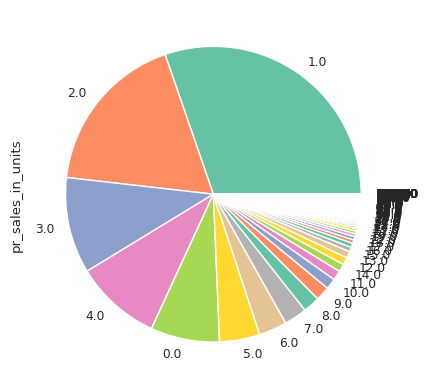

In [ ]:
sales_df_train['pr_sales_in_units'].value_counts(vars).plot(kind='pie');

In [ ]:
sales_df_train[sales_df_train['pr_sales_in_units'] < 0]['pr_sales_in_units'].count()

71

In [ ]:
sales_df_train[(sales_df_train['pr_promo_sales_in_units'] == 0) &
               (sales_df_train['pr_promo_sales_in_rub'] > 0)][
    'pr_sales_in_rub'].to_frame(name = 'Продажи при нулевом количестве')

,Продажи при нулевом количестве
3,69.0
38,136.0
75,48.0
97,32.0
115,84.0
...,...
882924,61.0
882978,30.0
882991,70.0
883004,41.0


In [ ]:
sales_df_train[sales_df_train['pr_promo_sales_in_units'] < 0]['pr_promo_sales_in_units'].count()

35

In [ ]:
sales_df_train[(sales_df_train['pr_sales_in_rub'] == 0) &
               (sales_df_train['pr_sales_in_units'] > 0)]['pr_sales_in_rub'].count()

794

In [ ]:
sales_df_train[sales_df_train['pr_sales_in_rub'] < 0]['pr_sales_in_rub'].count()

78

In [ ]:
sales_df_train[(sales_df_train['pr_promo_sales_in_rub'] == 0) &
               (sales_df_train['pr_promo_sales_in_units'] > 0)]['pr_promo_sales_in_rub'].count()

677

In [ ]:
sales_df_train[sales_df_train['pr_promo_sales_in_rub'] < 0]['pr_promo_sales_in_rub'].count()

36

- В бинарном столбце с флагом наличия промо: примерно 60% товаров проданы без него, 40% с ним соответственно в распределении данных по количеству проданных единиц товаров (с промо и без) и по продажам(с промо и без);

- Количество проданных без промо: медиана - 2, мин 1 максимум 4, максимальное значение выброса достигает 2348, 66089(7%) строки содержат нулевые данные, несмотря на то, что продажи в этих строчках присутствуют, есть отрицательные значения в количествах (несмотря на то, что возможно это были возвраты в день без покупок, такиx значений крайне мало - 71 штука, поэтому их удаляем);

- Количество проданных с промо: среднее - 2, из-за большой дисперсии, в основном данные распределены вокруг значения 1. Также присутствуют нулевые значения при ненулевых продажах, здесь это 31006(3.5%), также есть отрицательные значения - 35 шт (также удаляем);

- Продажи в рублях: медиана в районе 250, распределение смещено вправо, поэтому среднее больше медианы почти в два раза, есть нулевые продажи при ненулевом количестве проданных единиц - 794 строки, есть отрицательные значения - 78 строк;

- Продажи промо в рублях: данные очень разреженные, среднее опять вдвое больше медианы, 677 строк с нулевыми данными, при наличии в строке проданных единиц с промо, 36 отрицательных значений.

In [ ]:
sales_df_train = sales_df_train[((sales_df_train['pr_sales_in_units'] != 0) &
                                 (sales_df_train['pr_sales_in_rub'] != 0)) | \
    ((sales_df_train['pr_sales_in_units'] == 0) & (sales_df_train['pr_sales_in_rub'] == 0))]

In [ ]:
sales_df_train = sales_df_train[(sales_df_train['pr_sales_in_units'] >= 0) &
                                (sales_df_train['pr_promo_sales_in_units'] >= 0) &
                                (sales_df_train['pr_sales_in_rub'] >= 0) \
     & (sales_df_train['pr_promo_sales_in_rub'] >= 0)]

In [ ]:
sales_df_train.shape[0]*100/883015

92.41756935046403

Итак, удалены данные, где не совпадало присутствие нулевых значений в столбцах с количеством и продажами, и с отрицательными значениями в этих данные (7,6% от датасета).

Теперь проверим данные на гетероскедастичность, подгоним простую модель линейной регрессии, используя количество проданных единиц в качестве зависимой переменной, предиктором выступят продажи. Построим график несвязок по сравнению с подобранным. Далее проведем тест Бреуша-Пагана для проверки данных на гетероскедастичность:

In [ ]:

res = smf.ols('pr_sales_in_units ~ pr_sales_in_rub', data=sales_df_train).fit()

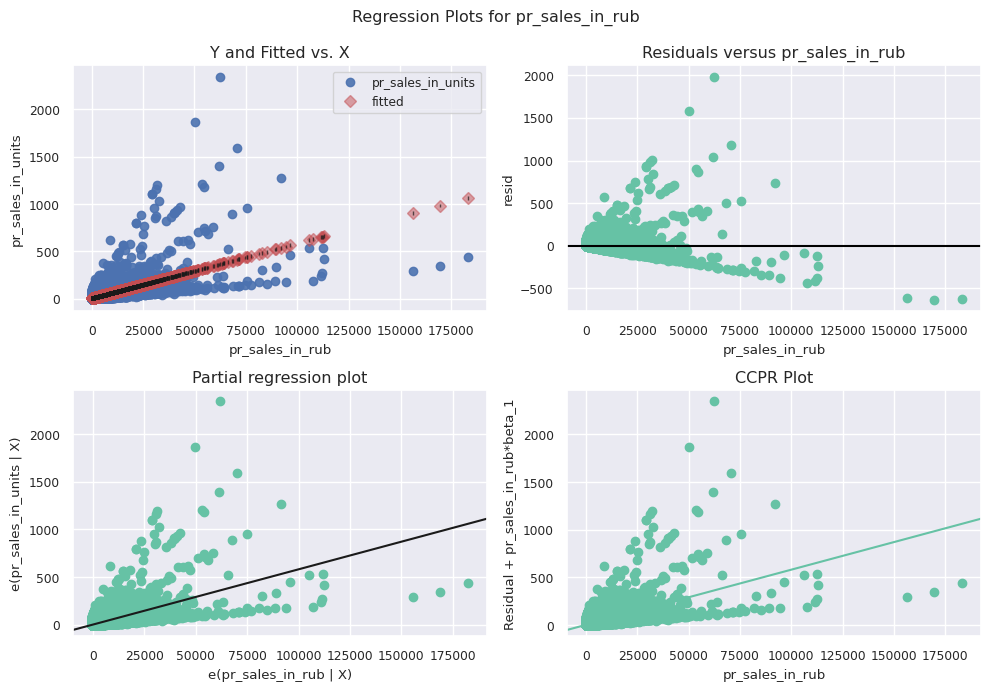

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(10, 7))
fig = sm.graphics.plot_regress_exog(res, 'pr_sales_in_rub', fig=fig)

Визуально заметно, что остатки становятся более разбросанными при более высоких значениях на графике, это указаывает на наличие гетероскедастичности. Но необходимо провести тест.

- Нулевая гипотеза - присутствует гомоскедастичность.

- Альтернативная гипотеза - отсутствует гомоскедастичность(присутствует гетероскедастичность).

In [ ]:
names = ['Lagrange multiplier statictic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(res.resid, res.model.exog)
lzip(names, test)

[('Lagrange multiplier statictic', 38407.41217252289),
 ('p-value', 0.0),
 ('f-value', 40304.211104662485),
 ('f p-value', 0.0)]

p-value ниже 0.05, мы можем отвергнуть нулевую гипотезу и предположить, что в данных присутствует гетероскедастичность. Так как это будет негативно сказываться на работе регрессионных моделей, необходимо ее исправлять (преобразовывать зависимую переменную, использовать взвешенную регрессию).

#### Анализ магазинов

In [ ]:
read_data(sf_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes
None
                              st_id                        st_city_id  \
0  1aa057313c28fa4a40c5bc084b11d276  1587965fb4d4b5afe8428a4a024feb0d   
1  bd470ca955d9497bbcb808e59952fffc  955d864a62659945cc9434898e275deb   
2  6364d3f0f495b6ab9dcf8d3b5c6e0b01  b8b4b727d6f5d1b61fff7be687f7970f   
3  1ecfb463472ec9115b10c292ef8bc986  908c9a564a86426585b29f5335b619bc   
4  16a5cdae362b8d27a1d8f8c7b78b4330  c1f75cc0f7fe2

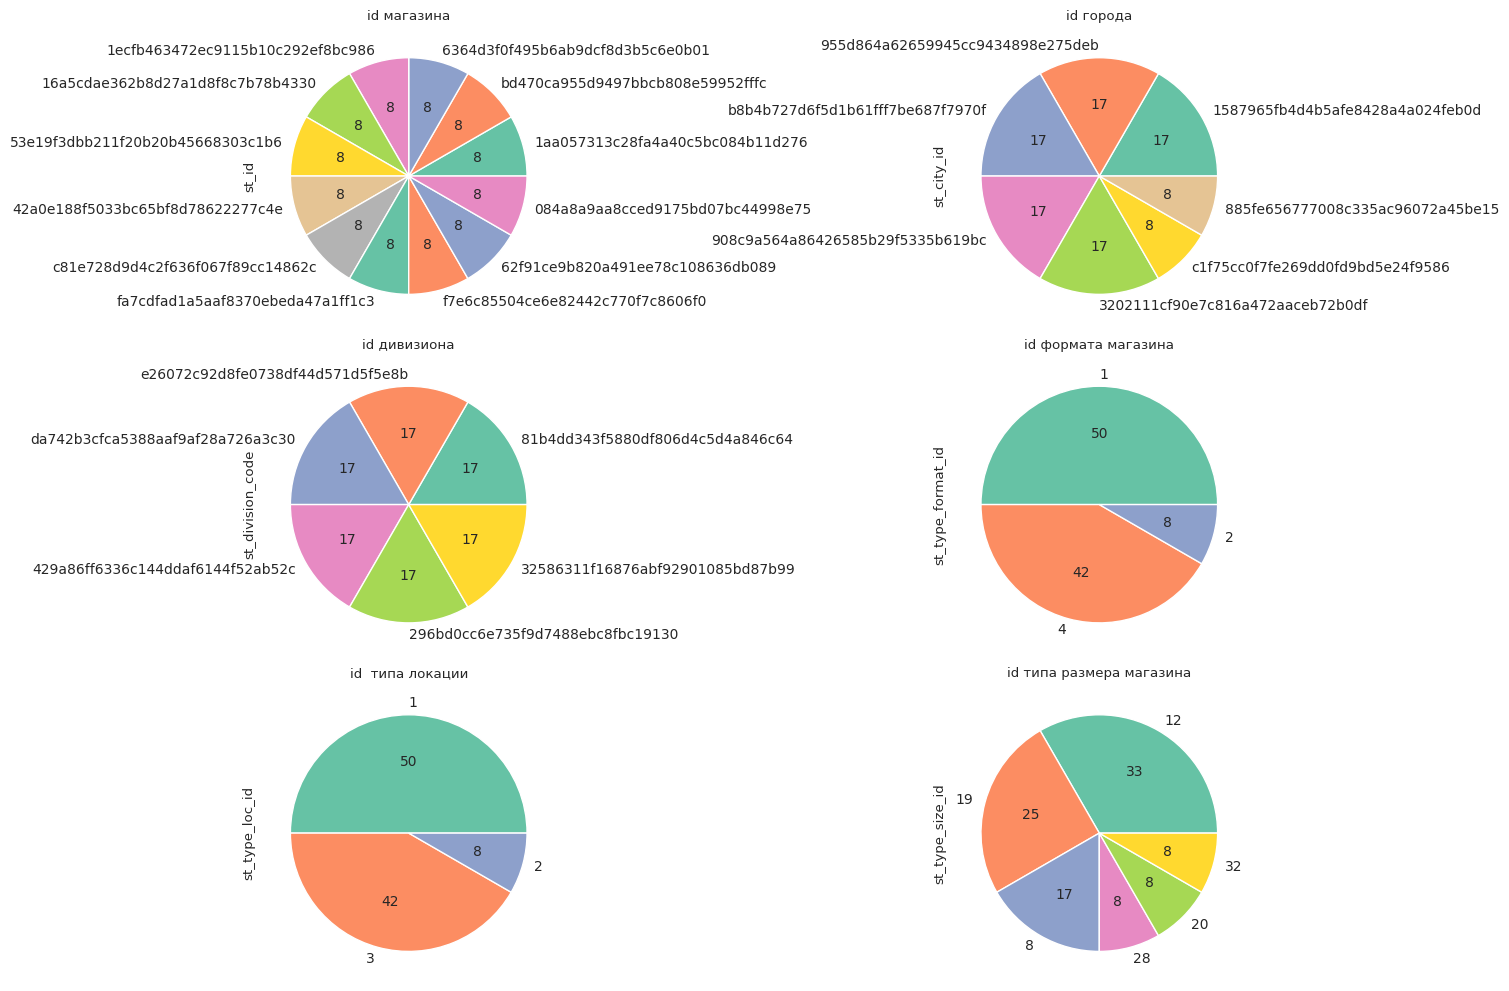

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(14, 10))
autopct='%.0f'
font_size=10
sf_df['st_id'].value_counts().plot.pie(autopct=autopct,fontsize=font_size, ax=axs[0, 0])\
    .set_title('id магазина')
sf_df['st_city_id'].value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[0, 1])\
    .set_title('id города')
sf_df['st_division_code'].value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[1, 0])\
    .set_title('id дивизиона')
sf_df['st_type_format_id'].value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[1, 1])\
    .set_title('id формата магазина')
sf_df['st_type_loc_id'].value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[2, 0])\
    .set_title('id  типа локации')
sf_df['st_type_size_id'].value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[2, 1])\
    .set_title('id типа размера магазина')
fig.tight_layout()

In [ ]:
sf_df['st_is_active'].value_counts().to_frame()

,st_is_active
1,10
0,2


Вывод по магазинам:
    
- 2 магазина из 12 неактивны;

- 12 магазинов распределены в равной пропорции примерно по 8%;

- представлены 7 городов(на 5 приходится по 17% на 2 по 8%);

- есть 6 дивизионов(равномерно по 17%);

- закодированный формат магазина("1"-50%б "4"-42%, "2"-8%);

- три типа локации("1"-50%б "3"-42%, "2"-8%);

- 6 типов размерности магазинов("12"-33%, "19"-25%, "8"-17%, "20","28","32" - по 8%).

### Объединение данных

Для начала объединим наши данные в один датасет:

In [ ]:
data = sales_df_train.merge(sf_df, on = 'st_id').merge(pr_df, on = 'pr_sku_id')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816061 entries, 0 to 816060
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    816061 non-null  object        
 1   pr_sku_id                816061 non-null  object        
 2   date                     816061 non-null  datetime64[ns]
 3   pr_sales_type_id         816061 non-null  int64         
 4   pr_sales_in_units        816061 non-null  float64       
 5   pr_promo_sales_in_units  816061 non-null  float64       
 6   pr_sales_in_rub          816061 non-null  float64       
 7   pr_promo_sales_in_rub    816061 non-null  float64       
 8   st_city_id               816061 non-null  object        
 9   st_division_code         816061 non-null  object        
 10  st_type_format_id        816061 non-null  int64         
 11  st_type_loc_id           816061 non-null  int64         
 12  st_type_size_id 

In [ ]:
data.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
1,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-02-02,1,1.0,1.0,107.0,107.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
2,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-09,1,1.0,1.0,167.0,167.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
3,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-06-30,1,25.0,25.0,3766.0,3766.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
4,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-12-29,0,49.0,0.0,9143.0,0.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1


In [ ]:
data[(data['pr_sales_in_units'] == data['pr_promo_sales_in_units']) &
     (data['pr_sales_in_rub'] == data['pr_promo_sales_in_rub'])] \
    .shape[0]/data.shape[0]

0.40122000683772413

Около 40% данных по количеству и сумме продаж идентичны, оставшаяся часть суммы и количества продаж без промо во всех случаях превышает соответствующие значения с флагом промо, отсюда делаем вывод что признаки количество проданных единиц и продажи в рублях включают в себя соотвествующие количества и суммы продаж с флагом промо.

Итого: целевая переменная количество проданных товаров без признака промо

(0.0, 600.0)

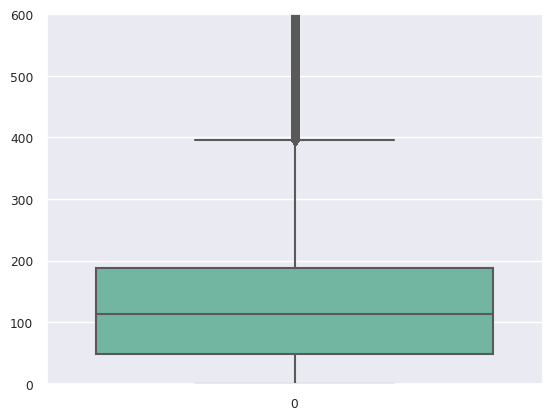

In [ ]:
sns.boxplot(data=round(data['pr_sales_in_rub']/data['pr_sales_in_units'], 1)).set_ylim(0, 600)

In [ ]:
round(data['pr_sales_in_rub']/data['pr_sales_in_units'], 1).median()

113.1

In [ ]:
round(data['pr_sales_in_rub']/data['pr_sales_in_units'], 1).describe()

count    815607.000000
mean        138.856970
std         127.099226
min           0.100000
25%          49.100000
50%         113.100000
75%         187.800000
max        4729.000000
dtype: float64

Распределение отношения суммы продаж/количество продаж: медианное значение 113.1, среднее 138, соотвественно распределение смещено вправо, присутствуют выбросы, обусловленные выбросами признака сумма продаж. Для дальнейшего анализа создам признак со средней ценой за день

In [ ]:
data['mean_price'] = round(data['pr_sales_in_rub']/data['pr_sales_in_units'], 1)

### Анализ временных рядов

In [ ]:
time_analys = data[['date', 'pr_sales_in_units']]

In [ ]:
time_analys.index=time_analys['date']

In [ ]:
time_analys.drop('date', axis=1, inplace=True)

In [ ]:
time_analys = time_analys['pr_sales_in_units']

In [ ]:
time_analys.index.is_monotonic_increasing

False

In [ ]:
time_analys = time_analys.resample('1D').sum()

In [ ]:
decomposed = seasonal_decompose(time_analys)

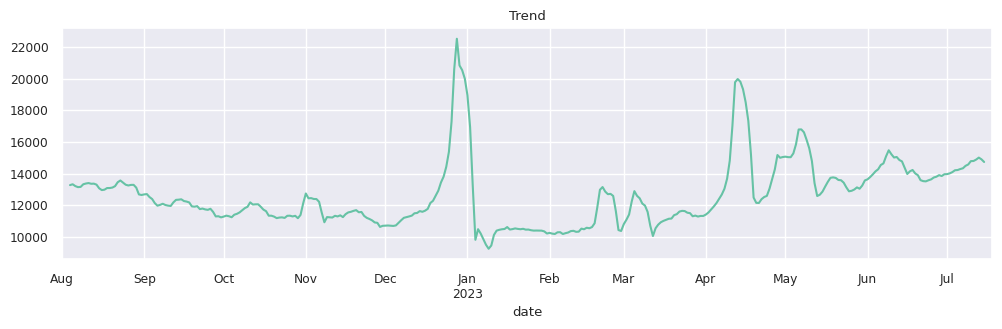

In [ ]:
plt.figure(figsize=(12,3))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend');

Мы видим яркий тренд возрастания количества покупок в период новогодних праздников, чуть менее выраженные тренды, относящиеся к праздникам 23 февраля и 8 марта, также есть тренда возрастания количества покупок в середине апреля (начало сезона пикников), первой половине мая ("майские праздники").

Посмотрим на сезонность:

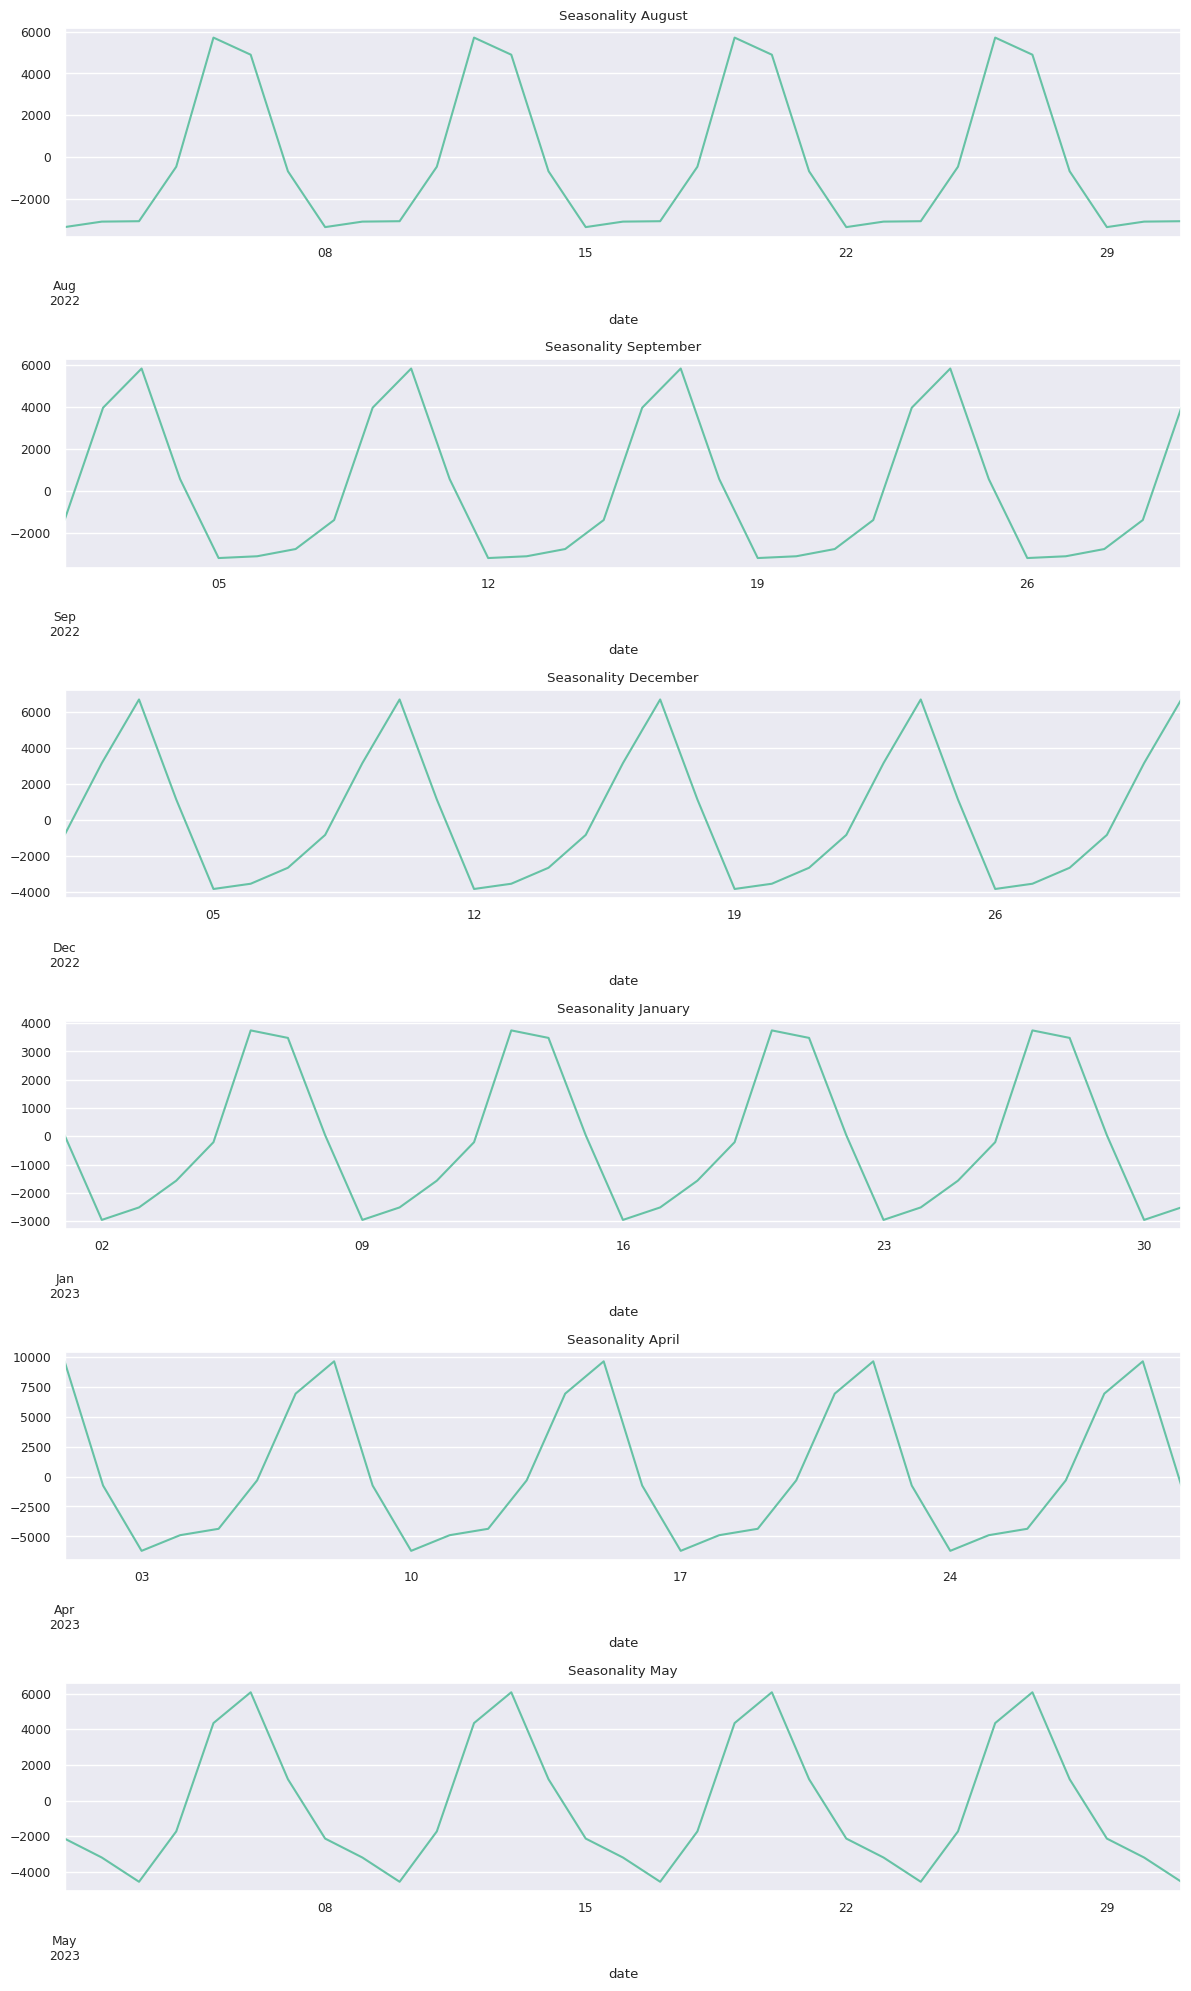

In [ ]:
plt.figure(figsize=(12,20))
plt.subplot(611)
seasonal_decompose(time_analys['2022-08-01':'2022-08-31']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality August')
plt.subplot(612)
seasonal_decompose(time_analys['2022-09-01':'2022-09-30']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality September')
plt.subplot(613)
seasonal_decompose(time_analys['2022-12-01':'2022-12-31']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality December')
plt.subplot(614)
seasonal_decompose(time_analys['2023-01-01':'2023-01-31']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality January')
plt.subplot(615)
seasonal_decompose(time_analys['2023-04-01':'2023-04-30']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality April')
plt.subplot(616)
seasonal_decompose(time_analys['2023-05-01':'2023-05-31']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality May')

plt.tight_layout()

По визуализации заметно, что точки максимума и минимума в помесячных графиках сезонности составляют разные значения, но тем не менее полный цикл изменения целевого признака во всех случаях около 7 дней.

Проведем тест Дики-Фуллера для проверки стационарности временного ряда, также построим графики автокорреляции:

In [ ]:
def tsplot(y, lags=None, figsize=(12, 4), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()
    return

Критерий Дики-Фуллера: p=0.014524


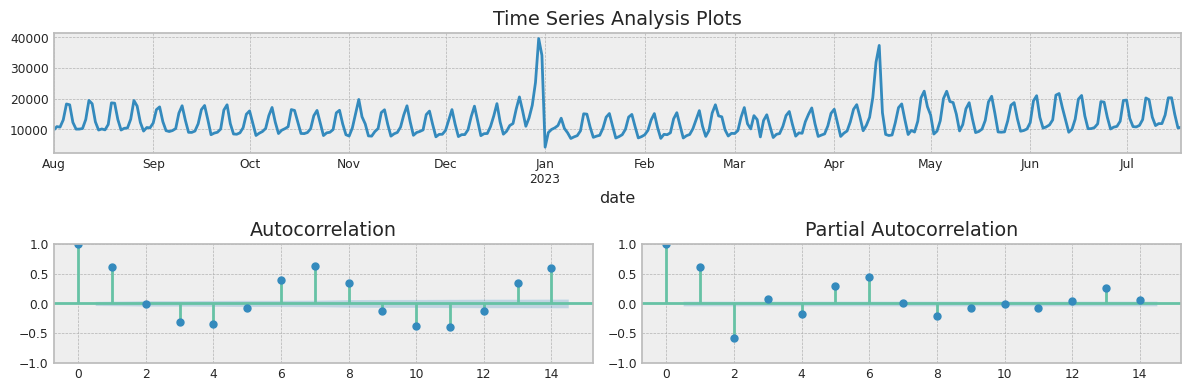

In [ ]:
tsplot(time_analys, lags=14)

Видим (и получаем подтверждение по критерию оценки Дики-Фуллера), что данный временной ряд относится к классу ТS (ряды, становящиеся стационарными после вычитания из них детерминированного тренда).

Также графики автокорреляции подтверждают гипотезу о том, что колебания целевой переменной укладываюся в период равный 7 дням (эта информация полезна для выбора размера скользящего окна).

### Анализ корреляционных связей

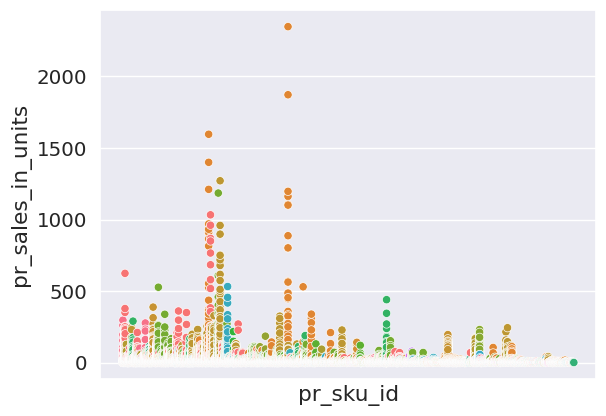

In [ ]:
sns.set(font_scale=1.3)
sns.scatterplot(
    x='pr_sku_id',
    y='pr_sales_in_units',
    data=data, hue='pr_cat_id',
    legend=False)
plt.xticks([])

plt.show()

Так выглядит распределение целевой переменной по товарам, подсвеченная по категориям товаров, визуально видно, что товары некоторых категорий пользуются гораздо большим спросом, но так как неудобно выводить достаточно длинные захэшированные названия категорий товарной иерархии, приведем эти распределения в табличном виде:

In [ ]:
data.groupby(['pr_group_id', 'pr_cat_id', 'pr_subcat_id'])['pr_sales_in_units']\
    .sum().sort_values(ascending=False).head(20).to_frame()

pr_sales_in_units
pr_group_id                      pr_cat_id                        pr_subcat_id                                       
c74d97b01eae257e44aa9d5bade97baf c559da2ba967eb820766939a658022c8 e06f5ed77191826c212c30722f2cc5a2           445606.0
6512bd43d9caa6e02c990b0a82652dca e58cc5ca94270acaceed13bc82dfedf7 c93c26cd49ea08e6b8984351d4164575           328480.0
                                                                  120e4b609af49ff7b17c3b90e7a28435           193552.0
aab3238922bcc25a6f606eb525ffdc56 186a157b2992e7daed3677ce8e9fe40f aa36dc1d45661519a5bf923429776a83           179511.0
c20ad4d76fe97759aa27a0c99bff6710 fb2fcd534b0ff3bbed73cc51df620323 45551f4c29881972ae5ed3666a5b1b8b           177175.0
c74d97b01eae257e44aa9d5bade97baf c559da2ba967eb820766939a658022c8 130d817d8b3f616e97c555ec57946aec           164110.0
                                                                  1e2248e0a1305fdf1dca5510e06a2b96           128173.0
                                                                  6e84696301885ba0a9dc8de6fe45abd0           117685.0
c20ad4d76fe97759aa27a0c99bff6710 fb2fcd534b0ff3bbed73cc51df620323 c005b9a2626f6c1946e1851628724b18           104787.0
6512bd43d9caa6e02c990b0a82652dca c9f95a0a5af052bffce5c89917335f67 126ad03316db7675164e3f0c8be270e9           103264.0
c74d97b01eae257e44aa9d5bade97baf 1bc0249a6412ef49b07fe6f62e6dc8de ca34f669ae367c87f0e75dcae0f61ee5            99462.0
aab3238922bcc25a6f606eb525ffdc56 28fc2782ea7ef51c1104ccf7b9bea13d b3e70d072fc648f6934c288e44f5c35e            96286.0
c74d97b01eae257e44aa9d5bade97baf c559da2ba967eb820766939a658022c8 34d2777e78ccf007523e2dd1fcea6b2d            91459.0
aab3238922bcc25a6f606eb525ffdc56 3de2334a314a7a72721f1f74a6cb4cee 0f3abfd67959c079e7b3759440e7415c            89953.0
                                 28fc2782ea7ef51c1104ccf7b9bea13d 7a8aebb07d6e8ba9da453ec0f3f359a4            89937.0
c74d97b01eae257e44aa9d5bade97baf 1bc0249a6412ef49b07fe6f62e6dc8de d407a3ebb4ab9b0d68b224486f8b8dad            84139.0
                                 c559da2ba967eb820766939a658022c8 89b0107c6d0aca5f15fa7a715f9e06e5            83330.0
                                 1bc0249a6412ef49b07fe6f62e6dc8de 1507fc0175c1ff0cf4440105bc6f93e6            82890.0
aab3238922bcc25a6f606eb525ffdc56 28fc2782ea7ef51c1104ccf7b9bea13d d29b5ce9c2883f0b7e90f79071a2ca82            76513.0
c74d97b01eae257e44aa9d5bade97baf f3173935ed8ac4bf073c1bcd63171f8a 5fd72b9fc7118bd36a137d7cea8c588a            73773.0

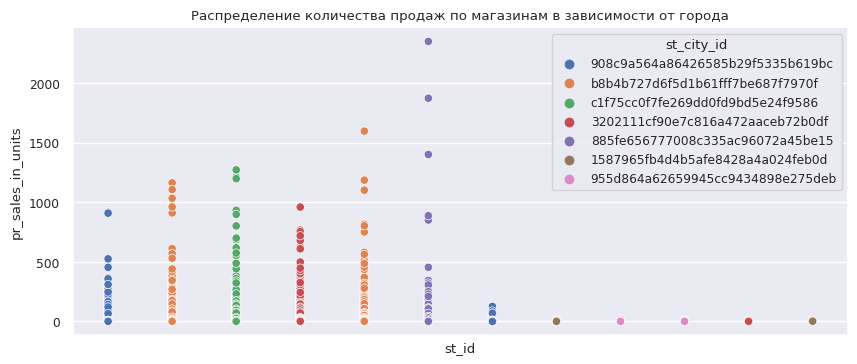

In [ ]:
sns.set(font_scale=0.8)
plt.figure(figsize=(10, 4))
sns.scatterplot(
    x='st_id',
    y='pr_sales_in_units',
    data=data, hue='st_city_id')
plt.xticks([])
plt.title('Распределение количества продаж по магазинам в зависимости от города')
plt.show()

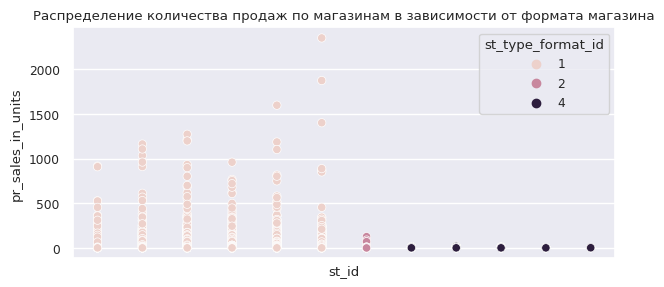

In [ ]:
sns.set(font_scale=0.8)
plt.figure(figsize=(7, 3))
sns.scatterplot(
    x='st_id',
    y='pr_sales_in_units',
    data=data, hue='st_type_format_id')
plt.xticks([])
plt.title('Распределение количества продаж по магазинам в зависимости от формата магазина')
plt.show()

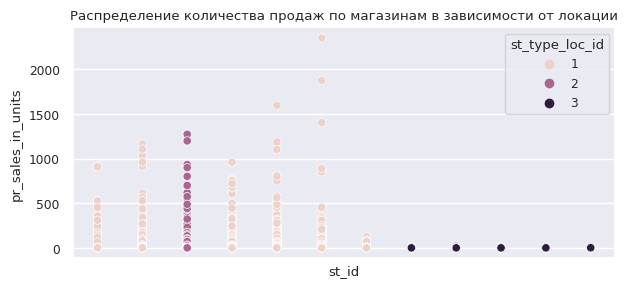

In [ ]:
sns.set(font_scale=0.8)
plt.figure(figsize=(7, 3))
sns.scatterplot(
    x='st_id',
    y='pr_sales_in_units',
    data=data, hue='st_type_loc_id')
plt.xticks([])
plt.title('Распределение количества продаж по магазинам в зависимости от локации')
plt.show()

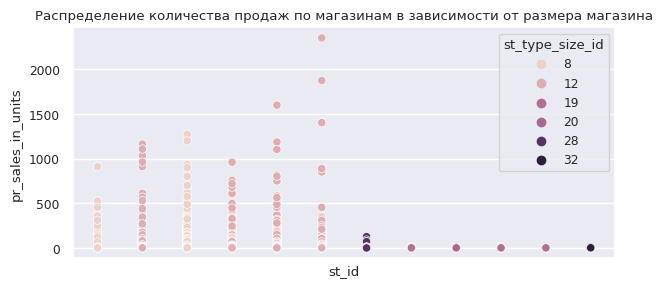

In [ ]:
sns.set(font_scale=0.8)
plt.figure(figsize=(7, 3))
sns.scatterplot(
    x='st_id',
    y='pr_sales_in_units',
    data=data, hue='st_type_size_id')
plt.xticks([])
plt.title('Распределение количества продаж по магазинам в зависимости от размера магазина')
plt.show()

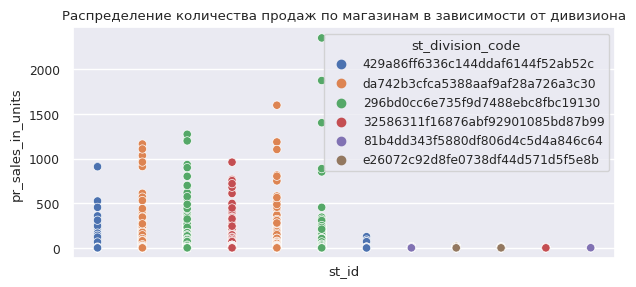

In [ ]:
sns.set(font_scale=0.8)
plt.figure(figsize=(7, 3))
sns.scatterplot(
    x='st_id',
    y='pr_sales_in_units',
    data=data, hue='st_division_code')
plt.xticks([])
plt.title('Распределение количества продаж по магазинам в зависимости от дивизиона')
plt.show()

В таблицах и на графиках явно заметна зависимость как целевой переменной от категорий товарной иерархии, так и от категорий данных по магазинам. Следовательно необходимо внести эти данные в качестве категориальных признаков для работы с моделями.

### Удаление неработающих магазинов

Существуют несколько магазинов с неактивным флагом на данный момент, удалим эти данные, так как прогноз спроса будет рассчитываться для рабочих ТК:

In [ ]:
data = data[data.st_is_active==1]

### Выбросы

Необходимо проверить выбросы со слишком большим количеством продаж, чтобы принять решение об их включение в итоговый состав признаков:

- выделим количество продаж, распределение которых больше 95 процентиля;
- при помощи таблицы holidays отделим праздники

In [ ]:
data[data['pr_sales_in_units'] > np.percentile(data['pr_sales_in_units'], 95)]['pr_sales_in_units'] \
    .sort_values(ascending=False).head(20).to_frame()

,pr_sales_in_units
637081,2348.0
637072,1872.0
432798,1596.0
432807,1400.0
478385,1271.0
432758,1211.0
637021,1197.0
473059,1185.0
636987,1162.0
637002,1106.0


In [ ]:
data.groupby(['st_id'])['pr_sales_in_units'].sum()

st_id
084a8a9aa8cced9175bd07bc44998e75        49.0
16a5cdae362b8d27a1d8f8c7b78b4330    872059.0
1ecfb463472ec9115b10c292ef8bc986    129101.0
42a0e188f5033bc65bf8d78622277c4e    725003.0
53e19f3dbb211f20b20b45668303c1b6     19199.0
6364d3f0f495b6ab9dcf8d3b5c6e0b01    529375.0
bd470ca955d9497bbcb808e59952fffc      5112.0
c81e728d9d4c2f636f067f89cc14862c    958456.0
f7e6c85504ce6e82442c770f7c8606f0    673313.0
fa7cdfad1a5aaf8370ebeda47a1ff1c3    531353.0
Name: pr_sales_in_units, dtype: float64

Получается в наших данных большинство ТК имеют продаж за год более 120 тыс. позиций и только 3 ТК имеют очень малые показатели, это ТК под ключом:
- 084a8a9aa8cced9175bd07bc44998e75 (причем этот имеет всего 49 продаж за год).
- 53e19f3dbb211f20b20b45668303c1b6;
- bd470ca955d9497bbcb808e59952fffc.

Прощаться с данными работающих ТК не хочется, посмотрим на них подробнее:

In [ ]:
data[(data['st_id'] == '084a8a9aa8cced9175bd07bc44998e75')]

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,mean_price
503009,084a8a9aa8cced9175bd07bc44998e75,c4a665596d4f67cecb7542c9fad407ee,2023-05-06,1,3.0,3.0,405.0,405.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,1,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,45551f4c29881972ae5ed3666a5b1b8b,1,135.0
503010,084a8a9aa8cced9175bd07bc44998e75,c4a665596d4f67cecb7542c9fad407ee,2023-05-01,0,2.0,0.0,287.0,0.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,1,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,45551f4c29881972ae5ed3666a5b1b8b,1,143.5
816025,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-06-05,0,1.0,0.0,146.0,0.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,1,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,146.0
816026,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-29,0,1.0,0.0,146.0,0.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,1,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,146.0
816027,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-05-24,0,1.0,0.0,146.0,0.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,1,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,146.0
816028,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-12,1,1.0,1.0,81.0,81.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,1,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,81.0
816029,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-06-20,0,1.0,0.0,146.0,0.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,1,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,146.0
816030,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-06-29,0,1.0,0.0,146.0,0.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,1,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,146.0
816031,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-06-24,1,1.0,1.0,132.0,132.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,1,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,132.0
816032,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-07,1,1.0,1.0,81.0,81.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,1,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17,81.0


Возможно ТК не так давно открылся и данный вид продукции только входит в оборот, я бы не исключал ТК с малыми продажами. Может быть их можно будет объединить при обучении с другими ТК по типу или формату.

Посмотрим на распределение значений в столбце `pr_sales_in_units`:

(0.0, 100.0)

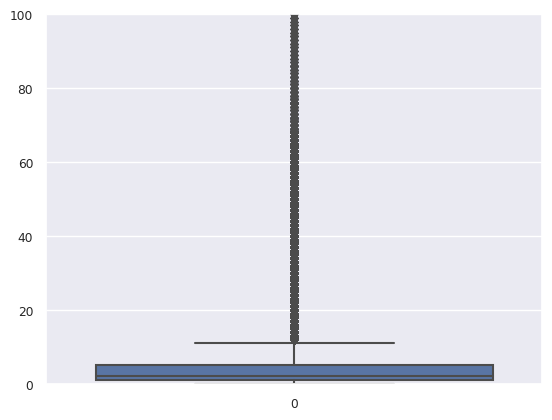

In [ ]:
sns.boxplot(data=data['pr_sales_in_units']).set_ylim(0, 100)


Как видим, выбросами является любая продажа больше 13 единиц за раз (для примера берем данные с более 250 продаж за день).

In [ ]:
data[(data['pr_sales_in_units'] > 250)]

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,mean_price
99,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-12-31,0,261.0,0.0,48748.0,0.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,186.8
1167,42a0e188f5033bc65bf8d78622277c4e,c7b711619071c92bef604c7ad68380dd,2022-12-31,0,297.0,0.0,42808.0,0.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,144.1
17497,16a5cdae362b8d27a1d8f8c7b78b4330,62d4af457ba2540ce0898a211c0cd17a,2022-09-16,0,254.0,0.0,4485.0,0.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,17.7
17994,16a5cdae362b8d27a1d8f8c7b78b4330,62d4af457ba2540ce0898a211c0cd17a,2022-12-30,0,351.0,0.0,7661.0,0.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,21.8
18171,f7e6c85504ce6e82442c770f7c8606f0,62d4af457ba2540ce0898a211c0cd17a,2022-12-30,0,624.0,0.0,9039.0,0.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,14.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659063,42a0e188f5033bc65bf8d78622277c4e,6d6ca571e2a7d2ec70bd9c09aac38f92,2023-04-14,1,339.0,339.0,16645.0,16645.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,60787c41b04097dfea76addfccd12243,17,49.1
659112,6364d3f0f495b6ab9dcf8d3b5c6e0b01,6d6ca571e2a7d2ec70bd9c09aac38f92,2023-04-14,1,279.0,279.0,13662.0,13662.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,60787c41b04097dfea76addfccd12243,17,49.0
718368,42a0e188f5033bc65bf8d78622277c4e,8cad09283d1d6c5fb08daec8a576a72d,2022-08-08,0,345.0,0.0,169379.0,0.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,c51ce410c124a10e0db5e4b97fc2af39,5caf41d62364d5b41a893adc1a9dd5d4,4e96157c3c8c24f4761a7bc4411a2504,1,491.0
718371,42a0e188f5033bc65bf8d78622277c4e,8cad09283d1d6c5fb08daec8a576a72d,2023-03-21,1,440.0,440.0,183265.0,183265.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,c51ce410c124a10e0db5e4b97fc2af39,5caf41d62364d5b41a893adc1a9dd5d4,4e96157c3c8c24f4761a7bc4411a2504,1,416.5


Но у нас есть праздничные и выходные дни, когда люди покупают больше готовой продукции, поэтому логичнее считать за выброс обычный день с высокими продажами.

Для этого возьмем датасет с праздниками:

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
holidays = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lenta/holidays_covid_calendar.csv', index_col=[0], parse_dates=['date'], dayfirst=True)

In [ ]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3653 entries, 2015 to 2024
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   day      3653 non-null   int64         
 1   weekday  3653 non-null   int64         
 2   date     3653 non-null   datetime64[ns]
 3   calday   3653 non-null   int64         
 4   holiday  3653 non-null   int64         
 5   covid    3653 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 199.8 KB


In [ ]:
holidays = holidays.drop(columns=['day', 'weekday', 'calday', 'covid'], axis = 1)

In [ ]:
data['date'] = pd.to_datetime(data['date'])

In [ ]:
data = data.merge(holidays, on = 'date')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 815334 entries, 0 to 815333
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    815334 non-null  object        
 1   pr_sku_id                815334 non-null  object        
 2   date                     815334 non-null  datetime64[ns]
 3   pr_sales_type_id         815334 non-null  int64         
 4   pr_sales_in_units        815334 non-null  float64       
 5   pr_promo_sales_in_units  815334 non-null  float64       
 6   pr_sales_in_rub          815334 non-null  float64       
 7   pr_promo_sales_in_rub    815334 non-null  float64       
 8   st_city_id               815334 non-null  object        
 9   st_division_code         815334 non-null  object        
 10  st_type_format_id        815334 non-null  int64         
 11  st_type_loc_id           815334 non-null  int64         
 12  st_type_size_id 

In [ ]:
data.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,mean_price,holiday
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,165.0,0
1,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,0,18.0,0.0,3202.0,0.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,177.9,0
2,42a0e188f5033bc65bf8d78622277c4e,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,2.0,2.0,336.0,336.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,168.0,0
3,42a0e188f5033bc65bf8d78622277c4e,c7b711619071c92bef604c7ad68380dd,2022-10-20,0,12.0,0.0,2382.0,0.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,198.5,0
4,16a5cdae362b8d27a1d8f8c7b78b4330,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,1.0,1.0,129.0,129.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,129.0,0


В таблице `holidays` учтены тоько официальные государственные праздники, однако люди покупают готовую еду накануне прздников, чтобы отметить на работе (как вариант), соответственно, в будний день продажи могут подскочить вверх, например, 22 февраля, 7 марта или 29-30 декабря. Поэтому решил добавить эти даты к праздничным дням, чтобы не выбрасывать эти данные:

In [ ]:
data.loc[data['date'] == '2022-11-04', 'holiday'] = 1
data.loc[data['date'] == '2022-12-30', 'holiday'] = 1
data.loc[data['date'] == '2022-12-29', 'holiday'] = 1
data.loc[data['date'] == '2023-02-22', 'holiday'] = 1
data.loc[data['date'] == '2023-03-07', 'holiday'] = 1
data.loc[data['date'] == '2023-04-14', 'holiday'] = 1

In [ ]:
#data = data.set_index('date')

In [ ]:
#data = data.sort_index(ascending=True)

In [ ]:
data.describe()

,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_uom_id,mean_price,holiday
count,815334.000000,815334.000000,815334.000000,815334.000000,815334.000000,815334.000000,815334.000000,815334.000000,815334.0,815334.000000,814881.000000,815334.000000
mean,0.401077,5.449325,2.410595,639.750072,316.427287,1.099125,1.204885,11.502063,1.0,7.202435,138.949533,0.355299
std,0.490117,13.865978,11.491953,1634.034882,1457.635725,0.417408,0.437284,4.601625,0.0,7.795437,127.115938,0.478604
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,8.000000,1.0,1.000000,0.100000,0.000000
25%,0.000000,1.000000,0.000000,116.000000,0.000000,1.000000,1.000000,8.000000,1.0,1.000000,49.300000,0.000000
50%,0.000000,2.000000,0.000000,250.000000,0.000000,1.000000,1.000000,12.000000,1.0,1.000000,113.300000,0.000000
75%,1.000000,5.000000,2.000000,588.000000,147.000000,1.000000,1.000000,12.000000,1.0,17.000000,188.000000,1.000000
max,1.000000,2348.000000,2348.000000,183265.000000,183265.000000,4.000000,3.000000,28.000000,1.0,17.000000,4729.000000,1.000000


Глянем сколько теперь у нас составляют выбросы:

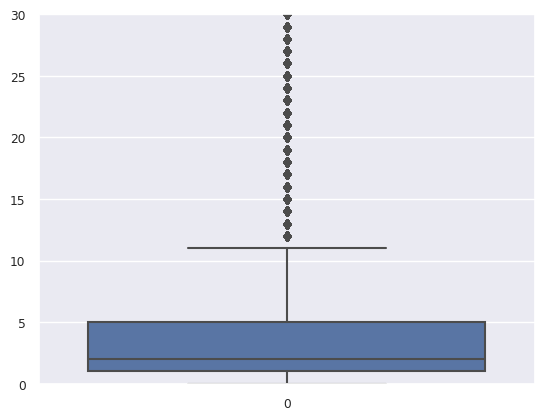

In [ ]:
sns.boxplot(data['pr_sales_in_units']).set_ylim(0, 30);

In [ ]:
data[(data['pr_sales_in_units'] > 13) & (data['holiday'] != 1)].shape

(35826, 20)

Осталось всего 35826 строки с продажами выше 13 шт в день, совершенных не в предпраздничные дни

In [ ]:
outliers = data[(data['pr_sales_in_units'] > 13) & (data['holiday'] == 0)]

In [ ]:
outliers_grouped=pd.DataFrame(outliers.groupby(outliers['date'])['pr_sales_in_units'].sum())

<Axes: xlabel='date', ylabel='pr_sales_in_units'>

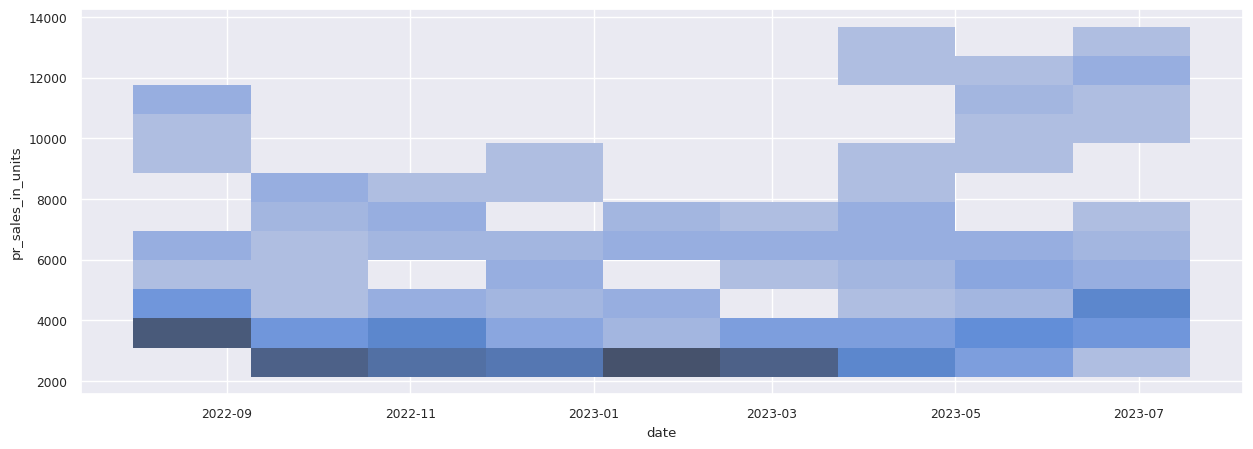

In [ ]:
plt.figure(figsize=(15, 5))
sns.histplot(data=outliers_grouped, x=outliers_grouped.index, y='pr_sales_in_units')

In [ ]:
outliers['date'].dt.day_name().value_counts().to_frame()

,date
Friday,11396
Thursday,7569
Wednesday,6066
Tuesday,5635
Monday,5160


In [ ]:
outliers['date'].dt.month_name().value_counts().to_frame()

,date
August,4189
June,4103
September,3468
May,3285
December,3018
October,2996
April,2857
November,2810
March,2672
July,2340


Посмотрим на имеющиеся взаимосвязи среди имеющихся признаков по средствам библиотеки phik (сразу преобразую некоторые категориальные признаки, имеющие числовой тип в object)&

Также построю тепловую карту корреляции для численных признаков

In [ ]:
data['pr_uom_id'] = data['pr_uom_id'].astype(str)
data['st_type_format_id'] = data['st_type_format_id'].astype(str)
data['st_type_loc_id'] = data['st_type_loc_id'].astype(str)
data['st_type_size_id'] = data['st_type_size_id'].astype(str)

In [ ]:
data.drop('date', axis=1).phik_matrix()

interval columns not set, guessing: ['pr_sales_type_id', 'pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub', 'st_is_active', 'mean_price', 'holiday']


,st_id,pr_sku_id,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,mean_price,holiday
st_id,1.000000,0.920496,0.098918,0.001429,0.000000,0.017038,0.016074,1.000000,1.000000,1.000000,1.000000,1.000000,0.172474,0.376970,0.558701,0.303604,0.051688,0.048498
pr_sku_id,0.920496,1.000000,0.385576,0.276119,0.302225,0.219096,0.205249,0.860283,0.878444,0.974781,0.890337,0.912770,1.000000,1.000000,1.000000,1.000000,0.914837,0.083523
pr_sales_type_id,0.098918,0.385576,1.000000,0.012785,0.016796,0.032208,0.038952,0.104251,0.061185,0.027295,0.029232,0.039057,0.178482,0.252511,0.292974,0.079984,0.068501,0.018980
pr_sales_in_units,0.001429,0.276119,0.012785,1.000000,0.998936,0.575806,0.568203,0.003991,0.002794,0.000000,0.000000,0.000000,0.016773,0.019192,0.069872,0.004452,0.000000,0.008042
pr_promo_sales_in_units,0.000000,0.302225,0.016796,0.998936,1.000000,0.584733,0.596932,0.002983,0.001095,0.000000,0.000000,0.000000,0.019662,0.023957,0.078331,0.004225,0.000000,0.005657
pr_sales_in_rub,0.017038,0.219096,0.032208,0.575806,0.584733,1.000000,0.999029,0.019520,0.015496,0.013735,0.031797,0.008138,0.073033,0.102343,0.147495,0.024247,0.061015,0.019278
pr_promo_sales_in_rub,0.016074,0.205249,0.038952,0.568203,0.596932,0.999029,1.000000,0.018540,0.013325,0.012441,0.030400,0.007655,0.072647,0.099188,0.141865,0.022639,0.055330,0.016460
st_city_id,1.000000,0.860283,0.104251,0.003991,0.002983,0.019520,0.018540,1.000000,1.000000,0.962538,1.000000,0.825703,0.176922,0.358959,0.530373,0.291632,0.053011,0.046940
st_division_code,1.000000,0.878444,0.061185,0.002794,0.001095,0.015496,0.013325,1.000000,1.000000,0.759529,0.832413,0.943417,0.166678,0.357952,0.540048,0.167092,0.030619,0.027594
st_type_format_id,1.000000,0.974781,0.027295,0.000000,0.000000,0.013735,0.012441,0.962538,0.759529,1.000000,0.944698,1.000000,0.251581,0.384849,0.582054,0.120440,0.064921,0.018443


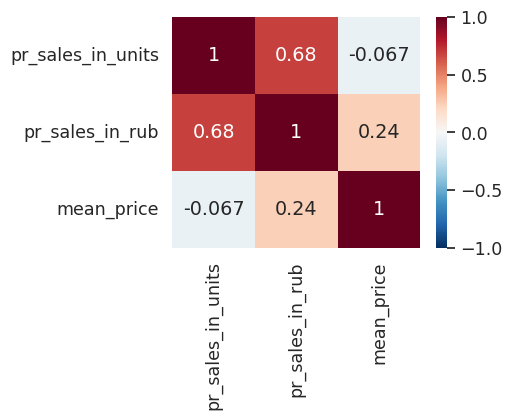

In [ ]:
sns.set(font_scale=1.15)
plt.figure(figsize=(4,3))
sns.heatmap(
    data[['pr_sales_in_units', 'pr_sales_in_rub', 'mean_price']].corr(),
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1);

phik матрица показывает взаимосвязи, имеющиеся как между численными, так между категориальными данными: если судить по ней все данные, относящиеся к иерархической структуре магазинов не имеют никакого влияния на целевую переменную, также и признак того продается ли товар поштучно или наразвес. Возьмем эти данные на вооружение, но пока эти признаки удалять не будем, примем решение на валидации (посмотрев еще и на важность признаков для модели).

Тепловая карта показывает крайне низкую корреляцию между целевой переменной и нововведенным столбцом со средней ценой, его мы удалим.

**Выводы:**

- определена целевая переменная - количество проданных единиц товара

- вновь созданный признак со средней ценой дает низкую корреляцию с целевой переменной, его тоже следует удалить

- судя по анализу временных рядов колебания целевой переменной укладываюся в интервал из 7 дней, эта информация будет учтена при выборе скользящего окна

- несмотря на результаты работы с библиотекой phik пока оставим в наборе признаков категориальные данные об иерархической структуре магазинов и бинарного столбца с типом продаваемой продукции(по крайней мере до изучения важности признаков для модели на валидации), данные по товарной иерархии также пока оставим в наборе признаков

- из датасета удалены данные из неактивных магазинов(в связи с их крайне маленьким размером), аналогичный столбец также удалю

- создан бинарный столбец является ли дата праздничным днем.

### Подготовка признаков

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 815334 entries, 0 to 815333
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    815334 non-null  object        
 1   pr_sku_id                815334 non-null  object        
 2   date                     815334 non-null  datetime64[ns]
 3   pr_sales_type_id         815334 non-null  int64         
 4   pr_sales_in_units        815334 non-null  float64       
 5   pr_promo_sales_in_units  815334 non-null  float64       
 6   pr_sales_in_rub          815334 non-null  float64       
 7   pr_promo_sales_in_rub    815334 non-null  float64       
 8   st_city_id               815334 non-null  object        
 9   st_division_code         815334 non-null  object        
 10  st_type_format_id        815334 non-null  object        
 11  st_type_loc_id           815334 non-null  object        
 12  st_type_size_id 

In [ ]:
data.drop(['pr_promo_sales_in_units', 'mean_price', 'st_is_active'], axis=1, inplace=True)

NameError: ignored

In [ ]:
start_date = '2022-08-01'
end_date = '2023-07-18'
date_seq = pd.date_range(start=start_date, end=end_date, freq='D')

In [ ]:
date_df = pd.DataFrame({'date': date_seq})

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 815334 entries, 0 to 815333
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   st_id                  815334 non-null  object        
 1   pr_sku_id              815334 non-null  object        
 2   date                   815334 non-null  datetime64[ns]
 3   pr_sales_type_id       815334 non-null  int64         
 4   pr_sales_in_units      815334 non-null  float64       
 5   pr_sales_in_rub        815334 non-null  float64       
 6   pr_promo_sales_in_rub  815334 non-null  float64       
 7   st_city_id             815334 non-null  object        
 8   st_division_code       815334 non-null  object        
 9   st_type_format_id      815334 non-null  object        
 10  st_type_loc_id         815334 non-null  object        
 11  st_type_size_id        815334 non-null  object        
 12  pr_group_id            815334 non-null  obje

In [ ]:
seq_df = data[['st_id', 'pr_sku_id', 'pr_sales_type_id', 'pr_sales_in_units', 'pr_sales_in_rub',
               'pr_promo_sales_in_rub', 'st_city_id', 'st_division_code', 'st_type_format_id',
               'st_type_loc_id', 'st_type_size_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id',
               'pr_uom_id', 'holiday']].drop_duplicates()

In [ ]:
date_grid = date_df.merge(seq_df, how = 'cross')

In [ ]:
date_grid['date'] = pd.to_datetime(date_grid['date'])

In [ ]:
temp_data = date_grid.merge(data[['st_id', 'pr_sku_id', 'date', 'pr_sales_in_units', 'pr_sales_in_rub']],
 on=['st_id', 'pr_sku_id', 'date'], how='left')

In [ ]:
temp_data.isna().sum()

In [ ]:
temp_data.fillna(0, inplace=True)

In [ ]:
temp_data.shape

In [ ]:
data = temp_data.groupby(['date', 'st_id', 'pr_sku_id', 'pr_sales_type_id', 'pr_sales_in_units',
                          'pr_sales_in_rub', 'pr_promo_sales_in_rub', 'st_city_id', 'st_division_code',
                          'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'pr_group_id',
                          'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'holiday']).agg(
    pr_sales_in_units=('pr_sales_in_units', 'sum'), pr_sales_in_rub=('pr_sales_in_rub', 'sum')).reset_index()

In [ ]:
data['date'].value_counts().to_frame()

In [ ]:
data['pr_sales_in_units'].value_counts().to_frame()

Итого нами получен датасет содержащий полный набор временных отметок для каждого уникального сочетания товар-магазин.

### Создание новых признаков

In [ ]:
data_1 = pd.read_csv('data.csv')

NameError: name 'pd' is not defined

In [ ]:
settings_comprehensive = settings.ComprehensiveFCParameters()

In [ ]:
enc = OrdinalEncoder()

In [ ]:
enc.fit(data[["st_id","pr_sku_id", "st_city_id", "st_division_code", "pr_group_id",
              "pr_cat_id", "pr_subcat_id"]])

OrdinalEncoder()

In [ ]:
data[["st_id","pr_sku_id", "st_city_id", "st_division_code",
          "pr_group_id", "pr_cat_id", "pr_subcat_id"]] =
enc.transform(data[["st_id", "pr_sku_id", "st_city_id", "st_division_code",
          "pr_group_id", "pr_cat_id", "pr_subcat_id"]])

In [ ]:
data_x = data.drop('total_sales', axis=1)[:50000]
data_y = data['total_sales'][:50000]

In [ ]:
print(data_x.shape)
print(data_y.shape)

(100000, 16)
(100000,)


In [ ]:
data_x_long = pd.DataFrame({0: data_x.values.flatten(),
                            1: np.arange(data_x.shape[0]).repeat(data_x.shape[1])})

In [ ]:
data_x_long.head()

,0,1
0,0.0,0
1,1.0,0
2,0.0,0
3,0.0,0
4,5.0,0


In [ ]:
data_x_long.shape

(1600000, 2)

In [ ]:
y.head()

0    5.0
1    1.0
2    4.0
3    1.0
4    2.0
Name: pr_sales_in_units, dtype: float64

In [ ]:
data_x_features = extract_features(data_x_long, column_id=1,
                                 default_fc_parameters=settings_comprehensive,
                                 impute_function=impute)

Feature Extraction: 100%|███████████████████████| 20/20 [21:26<00:00, 64.33s/it]


In [ ]:
data_x_features.shape

In [ ]:

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3)

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок
    return np.mean(np.array(errors))


#Значение длины сезона 24*7 возникло не случайно — в исходном ряде отчетливо видна дневная сезонность,
#(отсюда 24), и недельная — по будням ниже, на выходных — выше, (отсюда 7), суммарно сезонных компонент
#получится 24*7.